## Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

from tqdm import tqdm
from pathlib import Path
from itertools import product
from collections import Counter, defaultdict

# ringity imports
import ringity as rng
import ringity.utils.plotting as rplotting
import ringity.networks.networkmodel.distributions as rdist
import ringity.networks.networkmodel.transformations as rtrafo

from ringity.utils import exceptions as rexceptions

rplotting.set_theme()
DIRNAME_DATA = Path.cwd().parent / 'data'

### Set model parameters

In [2]:
N = 2**9

config_dict = {
    'default' : {
        'c' : 0.1,
        'r' : 0.25,
        'beta' : 1,
        'rho' : None,
    },
    'longer_response' : {
        'c' : 0.1,
        'r' : 0.375,
        'beta' : 1,
        'rho' : None,
    },
    'stronger_coupling' : {
        'c' : 0.1,
        'r' : 0.25,
        'beta' : 1,
        'rho' : None,
    },
    'shorter_delay' : {
        'c' : 0.1,
        'r' : 0.25,
        'beta' : 0.75,
        'rho' : None,
    },
    'higher_density_fixed_response' : {
        'c' : None,
        'r' : 0.375,
        'beta' : 1,
        'rho' : 0.05,
    },
    'higher_density_fixed_coupling' : {
        'c' : 0.1,
        'r' : None,
        'beta' : 1,
        'rho' : 0.05,
    }
}

### Auciliary functions

In [3]:
def draw_interaction_function(builder, ax):
    
    c = builder.coupling
    r = builder.response
    
    x = np.linspace(0, np.pi, 100)
    y = c*(1-x/(2*np.pi*r)).clip(0)

    ax.plot(x, y, linewidth = 5)

    plt.xticks([1, 2, 2*np.pi*r, np.pi], [r'$1$', r'$2$', r'$2\pi r$', r'$\pi$'])
    plt.yticks([0, 0.25, 0.5, 1, c], [r'$0$', r'$0.25$', r'$0.5$', r'$1$', r'$c$'])

    ax.set_ylim(-0.025, max(0.5, c) + 0.025)

# Network model exploration

## Default model

In [4]:
kwargs = config_dict['default']

G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                **kwargs)

In [5]:
circ_layout = {n:(np.cos(t), np.sin(t)) for n,t in enumerate(pos)}
spring_layout = nx.spring_layout(G)

### Interaction function

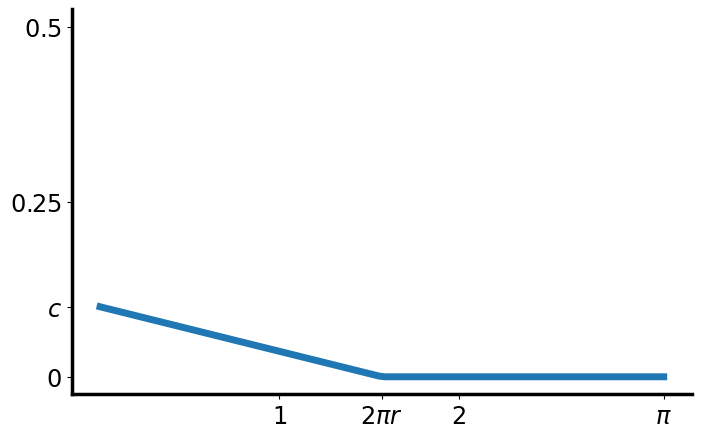

In [6]:
fig_func, ax = plt.subplots(figsize = (8,5))

draw_interaction_function(builder, ax)

### Network visualization

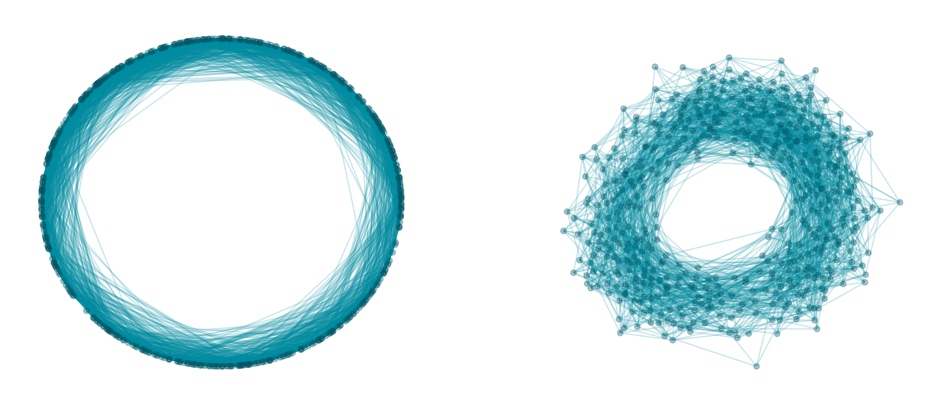

In [7]:
netviz_fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.set_xlim(-1.175,1.175)
ax1.set_ylim(-1.175,1.175)

ax2.set_xlim(-1.175,1.175)
ax2.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax1, pos = circ_layout)
rng.plot_nx(G, ax=ax2, pos = spring_layout)

### ring-score distribution

In [8]:
n_ensemble = 2**4
n_arg_points = 2**6

new_kwargs = {}
for k,v in kwargs.items():
    if kwargs[k] != config_dict['default'][k]:
        arg_name = k
    else:
        new_kwargs[k] = kwargs[k]

arg_list = np.linspace(0, 1, n_arg_points+1)[1:]

---

## Longer Response

In [9]:
configuration = 'longer_response'
kwargs = config_dict[configuration]

G, pos, builder = rng.network_model(
                                N = N,
                                return_positions = True, 
                                return_builder = True,
                                **kwargs)

In [10]:
circ_layout = {n:(np.cos(t), np.sin(t)) for n,t in enumerate(pos)}
spring_layout = nx.spring_layout(G)

### Interaction function

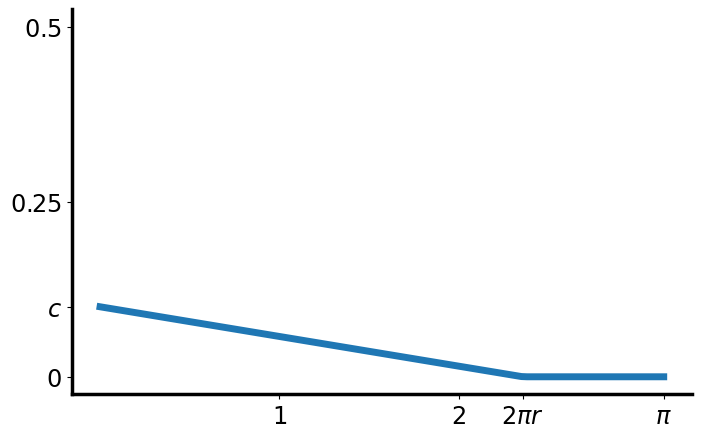

In [11]:
fig_func, ax = plt.subplots(figsize = (8,5))

draw_interaction_function(builder, ax)

### Network visualization

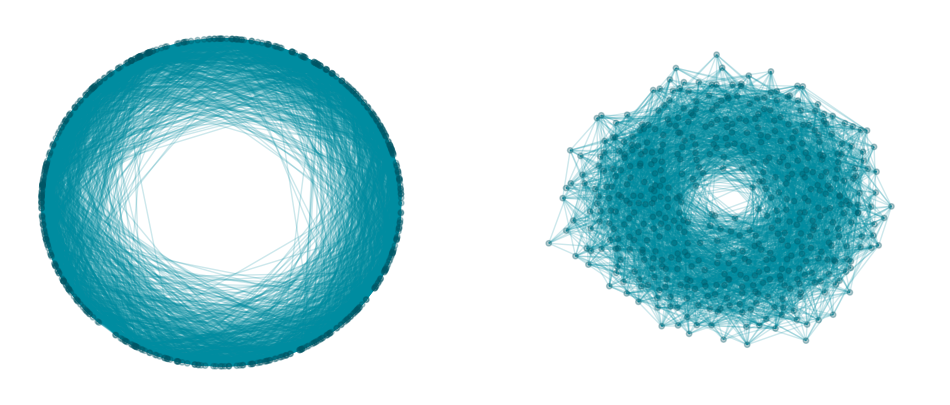

In [12]:
netviz_fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,5))

ax1.set_xlim(-1.175,1.175)
ax1.set_ylim(-1.175,1.175)

ax2.set_xlim(-1.175,1.175)
ax2.set_ylim(-1.175,1.175)

rng.plot_nx(G, ax=ax1, pos = circ_layout)
rng.plot_nx(G, ax=ax2, pos = spring_layout)

### Clustering coefficient

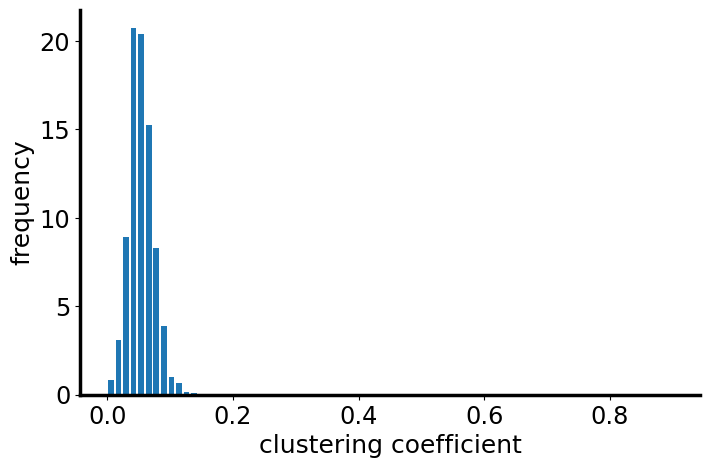

In [13]:
clust = []

for _ in range(2**6):
    G = rng.network_model(N=N, **config_dict[configuration])
    clust.extend(rng.networks.clustering_coefficient(G))

clust_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(clust, 
        bins=75, range=(0, 0.9), 
        rwidth = 0.75, density = True);

xlabel = ax.set_xlabel('clustering coefficient', fontsize=18)
ylabel = ax.set_ylabel('frequency', fontsize=18)

In [18]:
c = builder.coupling
r = builder.response
beta = builder.delay

degs_exp = [p for theta in rdist.delaydist.rvs(size=N, beta=beta) for p in np.random.binomial(N-1, rtrafo.local_density(theta=theta, r=r, c=c, beta=beta), size=2**10)]

degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

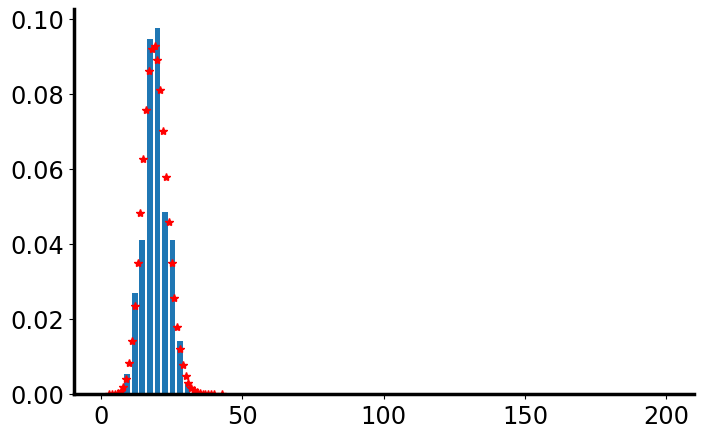

In [19]:
degs = []

for _ in range(2**6):
    G = rng.network_model(N=N, **config_dict[configuration])
    degs.extend([deg for n, deg in nx.degree(G)])

degs_obs, freqs_obs = zip(*Counter(degs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

deg_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(degs, 
        bins = 75, range = (0, 200),
        rwidth = 0.75, density = True);

ax.plot(degs_exp, freqs_exp, '*r')


#ax.set_xlabel('degree', fontsize=18)
#ax.set_ylabel('frequency', fontsize=18)

### Ring-score distribution

In [30]:
# Get parameter that deviates from default to use ase screening parameter
new_kwargs = {}
for arg_name in kwargs:
    if kwargs[arg_name] is None:
        continue
    elif kwargs[arg_name] != config_dict['default'][arg_name]:
        param_name = arg_name
    else:
        new_kwargs[arg_name] = kwargs[arg_name]

In [31]:
N = 2**8
n_ensemble = 2**4
n_arg_points = 2**6

arg_list = np.linspace(0, 1, n_arg_points+1)[1:]

total = len(arg_list) * n_ensemble
pbar = tqdm(product(arg_list, range(n_ensemble)), total = total)

score = defaultdict(list)
for arg, _ in pbar:
    G = rng.network_model(N = N, **new_kwargs, **{param_name : arg})
    try:
        score[arg].append(rng.ring_score(G))
    except rexceptions.DisconnectedGraphError:
        continue

100%|███████████████████████████████████████| 1024/1024 [01:45<00:00,  9.70it/s]


In [91]:
chunks_score_df = [
    pd.DataFrame(scores, columns=['score']).assign(r=arg) for arg, scores in score.items()
]

score_df = pd.concat(chunks_score_df, ignore_index=True)
plot_df = score_df.groupby('r').describe()['score']

Text(0, 0.5, 'score')

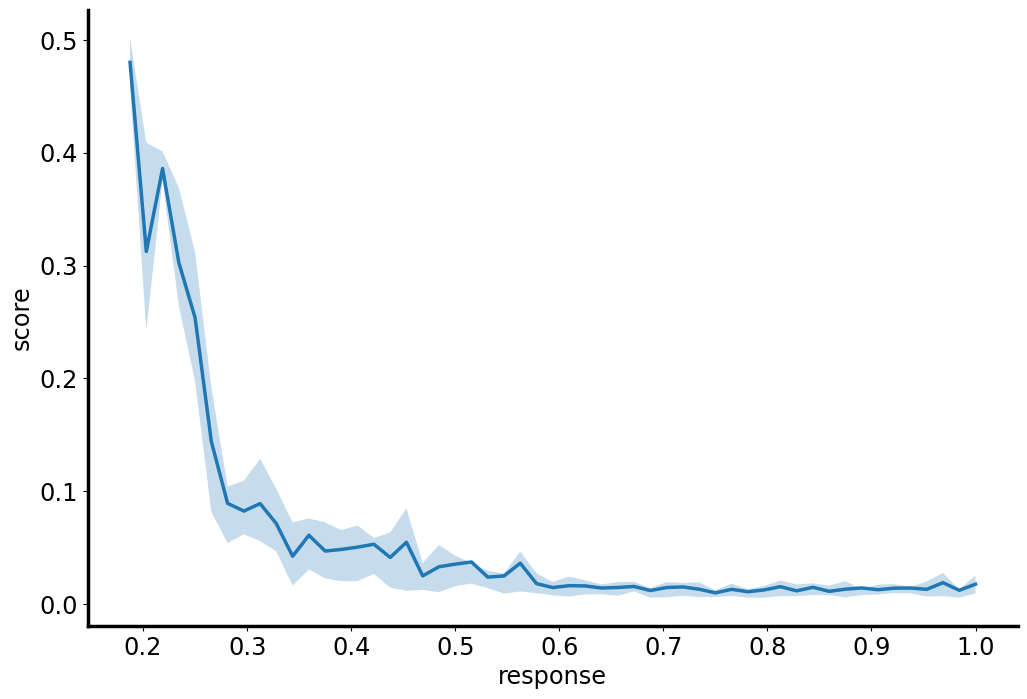

In [99]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(plot_df.index, plot_df['mean'], linewidth = 2.5)
ax.fill_between(plot_df.index, plot_df['25%'], plot_df['75%'], alpha = 0.25)

ax.set_xlabel('response')
ax.set_ylabel('score')

---

In [33]:
N = builder.N
c = builder.coupling
beta = rate_to_beta(builder.rate)

r_list = np.linspace(0, 1, 11)[1:]

In [34]:
score = defaultdict(list)

t1 = time.time()
for r in r_list:
    print(r)
    for _ in range(n_ensemble):
        G = rng.network_model(N=N, r=r, beta=beta, c = builder.coupling)
        score[r].append(rng.ring_score(G))
        
t2 = time.time()
print(20*'-')
print(t2 - t1)

0.1


DisconnectedGraphError: 

AttributeError: module 'ringity' has no attribute 'ax_setup'

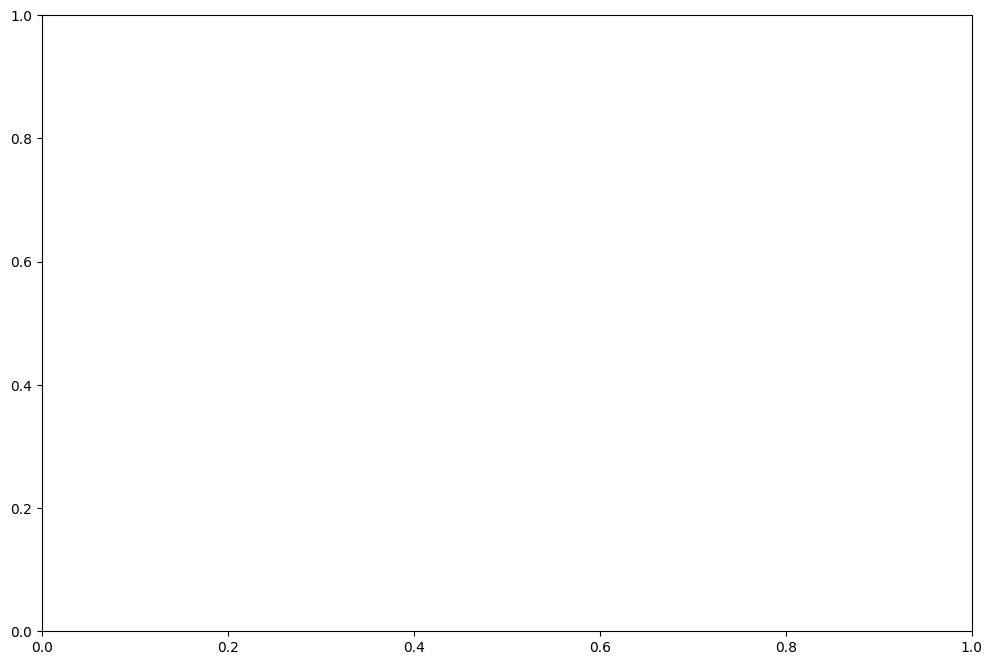

In [35]:
plot_df = pd.melt(pd.DataFrame(score))

fig, ax = plt.subplots(figsize = (12,8))
sns.lineplot(x = "variable", y = "value", data = plot_df, ax=ax, size=14)
rng.ax_setup(ax)
plt.savefig("/Users/markusyoussef/Desktop/test.png")

### Variing coupling

In [15]:
new_kwargs = {}

for k,v in kwargs.items():
    if kwargs[k] != config_dict['default'][k]:
        arg_name = k
    else:
        new_kwargs[k] = kwargs[k]

arg_list = np.linspace(0, 1, 11)[1:]

In [ ]:
score = defaultdict(list)

t1 = time.time()
for arg in arg_list:
    print(arg)
    for _ in range(n_ensemble):
        G = rng.network_model(N=N, **new_kwargs, **{arg_name : arg})
        score[r].append(rng.ring_score(G))
        
t2 = time.time()
print(20*'-')
print(t2 - t1)

0.1
0.2
0.30000000000000004
0.4


In [ ]:
G = rng.network_model(N=N, verbose = True, **new_kwargs, **{arg_name : arg})

In [27]:
n_ensemble = 2**4
N_list = [2**k for k in range(5, 9)]
r = builder.response
score = defaultdict(list)

t1 = time.time()
for N in N_list:
    print(N)
    for _ in range(n_ensemble):
        G = rng.network_model(N=N, c=c, r=r, beta=beta)
        score[N].append(rng.ring_score(G))
        
t2 = time.time()

print(t2 - t1)

19.147202968597412


In [28]:
plot_df = pd.melt(pd.DataFrame(score))

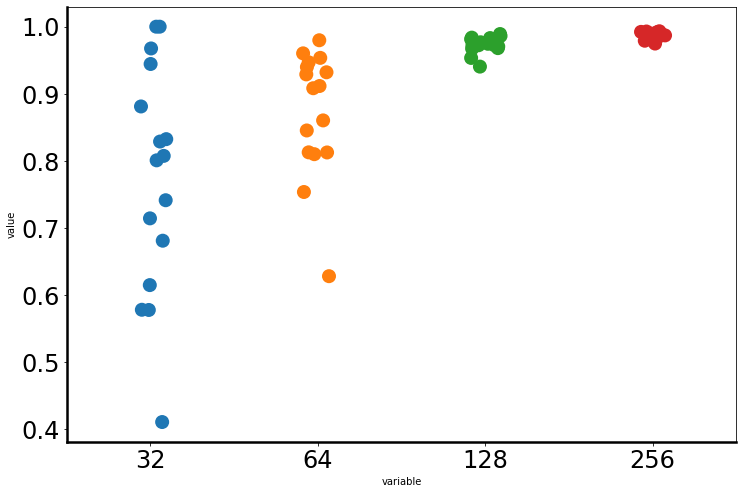

In [29]:
fig, ax = plt.subplots(figsize = (12,8))
sns.stripplot(x = "variable", y = "value", data = plot_df, ax=ax, size=14)
rng.ax_setup(ax)
plt.savefig("/Users/markusyoussef/Desktop/test.png")

## Clustering coefficient

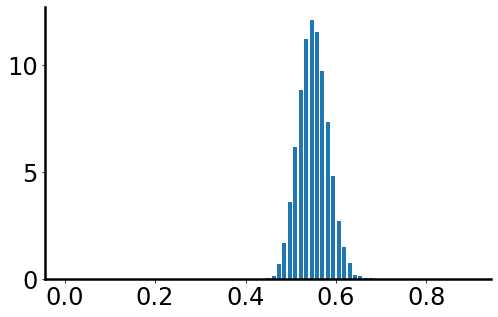

In [32]:
clust = []

for _ in range(2**6):
    G = rng.network_model(N=N, **config_dict[configuration])
    clust.extend(rng.clustering_coefficient(G))

clust_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(clust, 
        bins=75, range=(0, 0.9), 
        rwidth = 0.75, density = True);

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

rng.ax_setup(ax)

## Degree distribution

In [33]:
def expected_conditional_similarity(theta, rate, a):
    if np.isclose(rate, 0, atol=1e-7):
        return a
    
    if np.isclose(rate, np.inf):
        A = 1/(2*np.pi*a)
        B = A*np.pi
        C = B - 1
        return np.clip(np.abs(A*theta - B) - C, 0, 1)
    
    if theta < np.pi:
        if theta <= 2*np.pi*a:
            norm = 1 / (1 - np.exp(-2*np.pi*rate)) / (2*a*np.pi*rate)
            
            theta_term = -theta*rate * (1 - np.exp(-2*np.pi*rate))
            
            term1  = -2*np.exp(-rate*theta) + 1
            term21 =  np.exp(-rate*theta)*(np.exp(-2*a*np.pi*rate) + np.exp((2*a*np.pi - 2*np.pi)*rate))
            term22 = -np.exp(-2*np.pi*rate)
            
            return norm*(term1 + term21 + term22 + theta_term) + 1
        else:
            theta_term = np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
            alpha_term = (np.cosh(-rate*2*np.pi*a) - 1) / (a*np.pi*rate)
            return theta_term * alpha_term
        
    else:
        norm = 2*rate*np.exp(-rate*theta) / (1 - np.exp(-2*np.pi*rate))
        
        def undef_int(t):
            return (np.exp(np.pi*rate)*(np.cosh((np.pi - t)*rate) + (-2*a*np.pi + t)*rate*np.sinh((np.pi - t)*rate)))/(2*a*np.pi*rate**2)
        
        if 2*np.pi - theta <= 2*np.pi*a:
            term1 = (-1 + np.cosh((2*np.pi - theta)*rate) + (2*(-1 + a)*np.pi + theta)*rate*np.sinh((2*np.pi - theta)*rate))/(2*a*np.pi*rate**2)
            term2 = undef_int(2*np.pi*a) - undef_int(2*np.pi - theta)
            return norm*term1 + norm*term2
        else:
            return norm*(np.sinh(a*np.pi*rate)**2)/(a*np.pi*rate**2)

In [35]:
c = builder.coupling
r = builder.response
rate = builder.rate

degs_exp = [p for theta in pos for p in np.random.binomial(N-1, c*expected_conditional_similarity(theta=theta, rate=rate, a=r), size=2**10)]

In [36]:
degs_exp, freqs_exp = zip(*Counter(degs_exp).items())
freqs_exp = np.array(freqs_exp) / sum(freqs_exp)

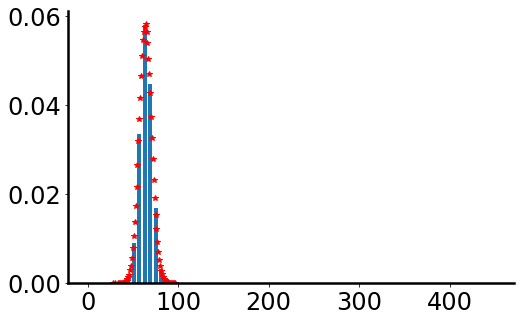

In [37]:
degs = []

for _ in range(2**6):
    G = rng.network_model(N=N, c=c, r=r, beta=beta)
    degs.extend([deg for n, deg in nx.degree(G)])

degs_obs, freqs_obs = zip(*Counter(degs).items())
freqs_obs = np.array(freqs_obs) / sum(freqs_obs)

deg_fig, ax = plt.subplots(figsize = (8,5))

ax.hist(degs, 
        bins = 75, range = (0, 450),
        rwidth = 0.75, density = True);

ax.plot(degs_exp, freqs_exp, '*r')


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.set_xlabel('degree', fontsize=24)
#ax.set_ylabel('frequency', fontsize=18)

rng.ax_setup(ax)

## Save data

In [98]:
fig_dir = Path("/Users/markusyoussef/Desktop/fig3/")

fig_func.savefig(fig_dir / f"{configuration}_interactionFunction.png")
fig_func.savefig(fig_dir / f"{configuration}_interactionFunction.pdf")

#netviz_circ_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_circular.png")
#netviz_circ_fig.savefig(f"/Users/dottolab/Desktop/fig3/{configuration}_network_circular.pdf")

netviz_spri_fig.savefig(fig_dir / f"{configuration}_network_spring.png")
netviz_spri_fig.savefig(fig_dir / f"{configuration}_network_spring.pdf")

clust_fig.savefig(fig_dir / f"{configuration}_clustering.png")
clust_fig.savefig(fig_dir / f"{configuration}_clustering.pdf")

deg_fig.savefig(fig_dir / f"{configuration}_degree.png")
deg_fig.savefig(fig_dir / f"{configuration}_degree.pdf")